# Setup

In [ ]:
import pandas as pd
import scipy
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

# Neural Likelihoods

## imports

In [ ]:
!git clone https://github.com/pawelc/NeuralLikelihoods.git chilinski2020neural
%cd chilinski2020neural

Cloning into 'chilinski2020neural'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 468 (delta 264), reused 398 (delta 195), pack-reused 0
Receiving objects: 100% (468/468), 11.85 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/chilinski2020neural


In [ ]:
import sys
sys.path.append('code')

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import json
from functools import reduce
import numpy as np

from conf import conf

import tensorflow as tf
tfk = tf.keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_datasets as tfds
K = tfk.backend

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot

from models.tensorflow.rnade import Rnade
from models.tensorflow.rnade_deep import RnadeDeep
from models.tensorflow.maf import MAF
from models.tensorflow.mdn import MDN
from models.tensorflow.monde import MONDE
from models.tensorflow.monde_ar_made import MondeARMADE
from data import registry
from models.tensorflow.compute import get_device
from utils import elapsed_timer
import utils as nl_utils

In [ ]:
from scipy.stats import bootstrap

In [ ]:
def loss_fn(_, log_prob):
    return -tf.reduce_mean(log_prob)

In [ ]:
''' # n_data = 10000
batch_size = 128
#max_epochs = 10000
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# device = get_device()
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
device = logical_gpus[0].name


K.clear_session()
with tf.device(device):
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal")
#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace")
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366
#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366
#     model = MAF(num_bijectors=2, hidden_units=[32,32], covariate_hidden_units=[16,16], batch_norm=False) #5,188
#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238
#     model = MONDE(cov_type="const_cov", arch_hxy=[64,64], arch_x_transform=[64,64], arch_cov_transform=None, hxy_x_size=32, covariance_learning_rate=None)
    model = MondeARMADE(arch = [32, 32], transform = 'sigm', x_transform_size = 16) # 2,241
    model.build([[None, 1], [None, 1]])


model.compile(optimizer = tfk.optimizers.Adam(), loss = loss_fn)
os.makedirs('test', exist_ok = True) '''

' # n_data = 10000\nbatch_size = 128\n#max_epochs = 10000\nos.environ[\'CUDA_VISIBLE_DEVICES\'] = \'0\'\n# device = get_device()\nlogical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\ndevice = logical_gpus[0].name\n\n\nK.clear_session()\nwith tf.device(device):\n#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="normal")\n#     model = Rnade(k_mix = 10, hidden_units=128, component_distribution="laplace")\n#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="normal") # 6,366\n#     model = RnadeDeep(k_mix = 10, arch=[64,64], component_distribution="laplace") # 6,366\n#     model = MAF(num_bijectors=2, hidden_units=[32,32], covariate_hidden_units=[16,16], batch_norm=False) #5,188\n#     model = MDN(arch=[64,64], num_mixtures=10) # 6,238\n#     model = MONDE(cov_type="const_cov", arch_hxy=[64,64], arch_x_transform=[64,64], arch_cov_transform=None, hxy_x_size=32, covariance_learning_rate=None)\n    model = MondeARMADE(arch = [32, 3

In [ ]:
def run_NL(train_D, test_D, dataset, max_epochs=10000):
    train_y = train_D[1].reshape(-1, 1)
    train_x = train_D[0].reshape(-1, 1)

    validation_y = test_D[1].reshape(-1, 1)
    validation_x = test_D[0].reshape(-1, 1)

    # n_data = 10000
    batch_size = 128
    #max_epochs = 10000
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # device = get_device()
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    device = logical_gpus[0].name


    train_dataset = tf.data.Dataset.from_tensor_slices(
            ((train_y, train_x), np.zeros((len(train_y), 0), dtype=np.float32)))
    train_dataset = train_dataset.repeat(None)
    train_dataset = train_dataset.shuffle(buffer_size=len(train_y))
    train_dataset = train_dataset.prefetch(3 * batch_size)
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices(
            ((validation_y, validation_x), np.zeros((len(validation_y), 0), dtype=np.float32)))
    val_dataset = val_dataset.repeat(1)
    val_dataset = val_dataset.prefetch(len(validation_y))
    val_dataset = val_dataset.batch(len(validation_y))


    K.clear_session()
    with tf.device(device):
        model = MondeARMADE(arch = [32, 32], transform = 'sigm', x_transform_size = 16) # 2,241
        model.build([[None, 1], [None, 1]])

    model.compile(optimizer = tfk.optimizers.Adam(), loss = loss_fn)
    os.makedirs('test', exist_ok = True)


    file_name = 'test/{}_{}'.format(model.model_name, dataset)

    model.save_to_json('{}.json'.format(file_name))


    callbacks = []
    callbacks.append(tfk.callbacks.TerminateOnNaN())
    callbacks.append(tfk.callbacks.ModelCheckpoint('{}.h5'.format(file_name),
                                                  monitor = 'val_loss', mode = 'min', verbose = 0, save_best_only = True, save_weights_only = True))
    callbacks.append(tfk.callbacks.History())
    # callbacks.append(tfk.callbacks.EarlyStopping(monitor = 'loss', patience = 30))

    steps_per_epoch = int(np.ceil(len(train_y) / batch_size))
    with elapsed_timer("training"):
        history = model.fit(x = train_dataset, validation_data = val_dataset, verbose = 1, epochs = max_epochs, steps_per_epoch = steps_per_epoch, callbacks = callbacks)

    # true_avg_ll = -np.mean(data_loader.ll(data_loader.validation_data))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = history.epoch, y = history.history['loss'], name = "train -ll"))
    fig.add_trace(go.Scatter(x = history.epoch, y = history.history['val_loss'], name = "validation -ll"))
    # fig.add_shape(go.layout.Shape(type = "line", xref = "paper", x0 = 0, y0 = true_avg_ll, x1 = 1, name = "true ll", y1 = true_avg_ll,
    #                               line = dict(color = "LightSeaGreen", width = 4,dash = "dashdot")))
    fig.update_layout(showlegend = True)
    iplot(fig);

    with tf.device(device):
        model = nl_utils.load_model_and_params(file_name)
    return model


## Gauss $\rho = 0.1$

In [ ]:
np.random.seed(30091985)

In [ ]:
rho = 0.1
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

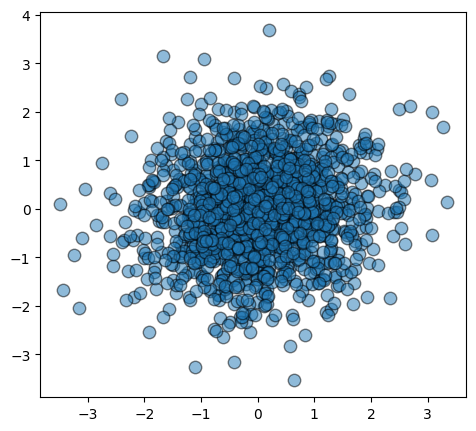

In [ ]:
visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D,'gauss_01', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 1.4062 - val_loss: 1.4668
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3799 - val_loss: 1.4695
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4131 - val_loss: 1.4707
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4126 - val_loss: 1.4666
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4152 - val_loss: 1.4670
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4319 - val_loss: 1.4659
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4022 - val_loss: 1.4658
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4342 - val_loss: 1.4717
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3901 - val_loss: 1.4670
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

1.4644569

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 1.4645 RMean: 1.4644 IC: (1.4005,1.5400) Notation: 1.46$\pm$0.08


## Gauss $\rho = 0.5$

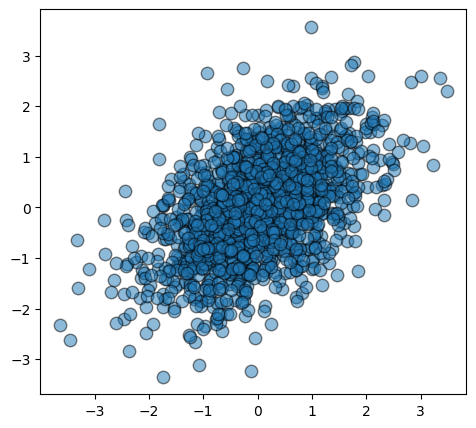

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'gauss_05', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 5ms/step - loss: 1.2598 - val_loss: 1.3278
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2799 - val_loss: 1.3256
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2697 - val_loss: 1.3275
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2765 - val_loss: 1.3259
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2603 - val_loss: 1.3260
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2656 - val_loss: 1.3299
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2876 - val_loss: 1.3277
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2493 - val_loss: 1.3267
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2839 - val_loss: 1.3265
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

1.323097

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 1.3231 RMean: 1.3231 IC: (1.2596,1.3995) Notation: 1.32$\pm$0.08


## Gauss $\rho = 0.9$

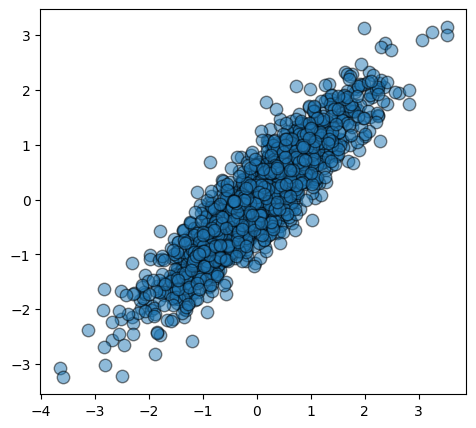

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'gauss_09', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 0.5701 - val_loss: 0.6438
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.6217 - val_loss: 0.6449
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5888 - val_loss: 0.6389
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5724 - val_loss: 0.6390
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5814 - val_loss: 0.6416
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5720 - val_loss: 0.6412
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.6000 - val_loss: 0.6396
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.6007 - val_loss: 0.6390
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5644 - val_loss: 0.6404
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

0.6292125

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 0.6292 RMean: 0.6292 IC: (0.5689,0.7019) Notation: 0.63$\pm$0.07


## Clayton $\theta = 1$

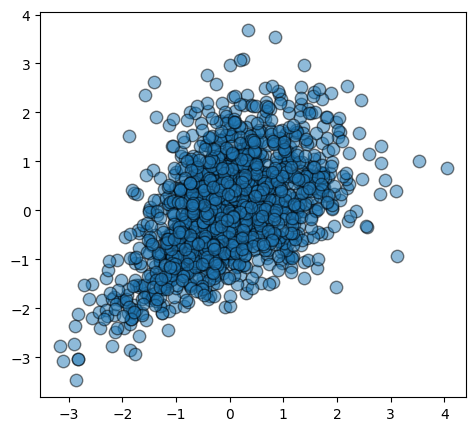

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_1', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 1.2936 - val_loss: 1.2022
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2505 - val_loss: 1.2028
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2684 - val_loss: 1.2024
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2473 - val_loss: 1.2033
Epoch 505/3000
12/12 [==============================] - 0s 5ms/step - loss: 1.2750 - val_loss: 1.2014
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2544 - val_loss: 1.2020
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2940 - val_loss: 1.2026
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2338 - val_loss: 1.2046
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.2557 - val_loss: 1.2015
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

1.1950133

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 1.1950 RMean: 1.1951 IC: (1.1436,1.2560) Notation: 1.20$\pm$0.06


## Clayton $\theta = 5$

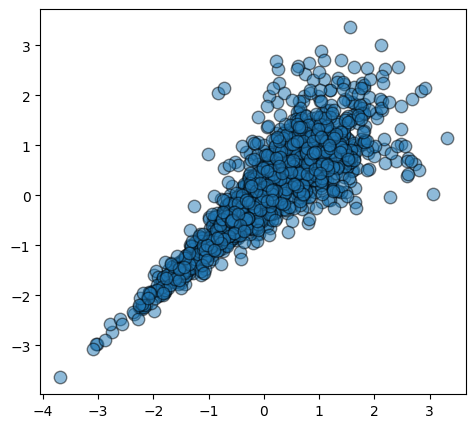

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_5', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 0.4989 - val_loss: 0.4723
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.4820 - val_loss: 0.4741
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5092 - val_loss: 0.4745
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.5090 - val_loss: 0.4709
Epoch 505/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.5034 - val_loss: 0.4702
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.4974 - val_loss: 0.4719
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.4932 - val_loss: 0.4706
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.4998 - val_loss: 0.4707
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.4705 - val_loss: 0.4712
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

0.46813172

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 0.4681 RMean: 0.4678 IC: (0.3897,0.5610) Notation: 0.47$\pm$0.09


## Clayton $\theta = 10$

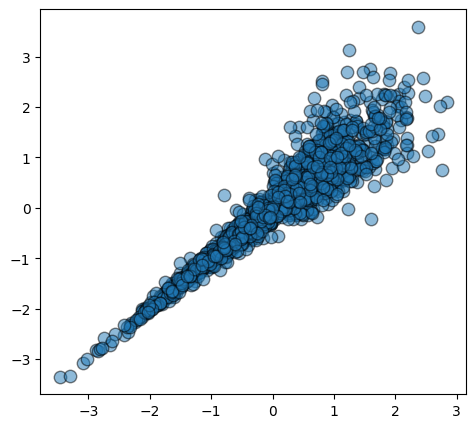

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model = run_NL(train_D, test_D, 'clayton_10', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: -0.0512 - val_loss: -0.0261
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0387 - val_loss: -0.0361
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0368 - val_loss: -0.0210
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0622 - val_loss: -0.0379
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0467 - val_loss: -0.0274
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0602 - val_loss: -0.0405
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0152 - val_loss: -0.0346
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0599 - val_loss: -0.0375
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: -0.0463 - val_loss: -0.0268
Epoch 510/3000
12/12 [======

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

-0.048432518

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: -0.0484 RMean: -0.0487 IC: (-0.1379,0.0554) Notation: -0.05$\pm$0.10


## Frank $\theta = 1$

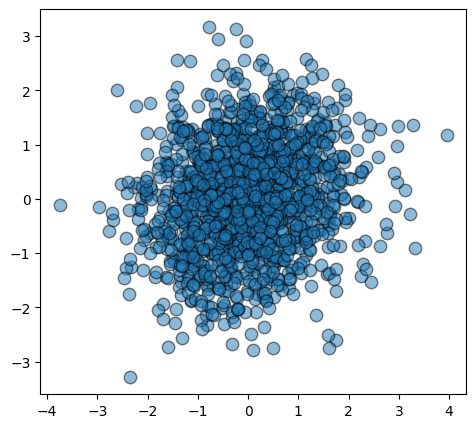

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_1', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 1.4068 - val_loss: 1.3971
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3987 - val_loss: 1.3999
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3825 - val_loss: 1.3959
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4185 - val_loss: 1.3958
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3691 - val_loss: 1.3971
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3989 - val_loss: 1.3975
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3861 - val_loss: 1.3965
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.4010 - val_loss: 1.3958
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.3732 - val_loss: 1.3972
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

1.3880283

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 1.3880 RMean: 1.3880 IC: (1.3301,1.4544) Notation: 1.39$\pm$0.07


## Frank $\theta = 5$

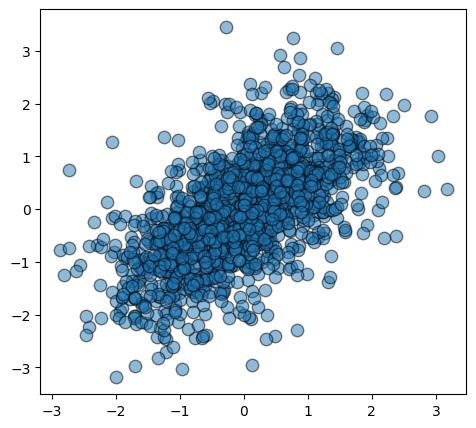

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_5', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 5ms/step - loss: 1.2015 - val_loss: 1.2758
Epoch 502/3000
12/12 [==============================] - 0s 5ms/step - loss: 1.1688 - val_loss: 1.2751
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1648 - val_loss: 1.2803
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1543 - val_loss: 1.2782
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1975 - val_loss: 1.2835
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1589 - val_loss: 1.2774
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1727 - val_loss: 1.2778
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1771 - val_loss: 1.2774
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 1.1858 - val_loss: 1.2768
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

1.2616296

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 1.2616 RMean: 1.2620 IC: (1.1867,1.3432) Notation: 1.26$\pm$0.08


## Frank $\theta = 10$

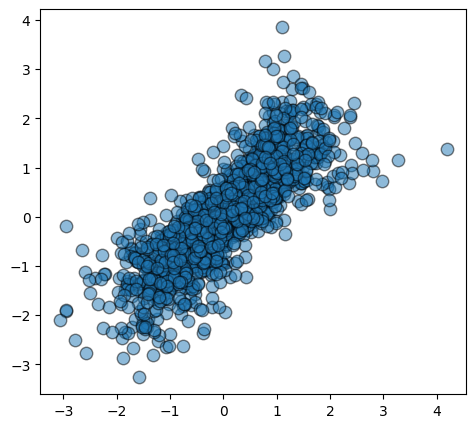

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
# train_D = scaler.fit_transform(train_D.T).T
# test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
model2 = run_NL(train_D, test_D, 'frank_10', max_epochs=3000)

Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 4ms/step - loss: 0.8246 - val_loss: 0.8614
Epoch 502/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8162 - val_loss: 0.8677
Epoch 503/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.7897 - val_loss: 0.8629
Epoch 504/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8213 - val_loss: 0.8621
Epoch 505/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.7993 - val_loss: 0.8631
Epoch 506/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8470 - val_loss: 0.8711
Epoch 507/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8100 - val_loss: 0.8631
Epoch 508/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8112 - val_loss: 0.8669
Epoch 509/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.8096 - val_loss: 0.8635
Epoch 510/3000
12/12 [========================

In [ ]:
validation_y = test_D[1].reshape(-1, 1)
validation_x = test_D[0].reshape(-1, 1)

prob = model2.prob(tf.convert_to_tensor(validation_y, dtype = float), tf.convert_to_tensor(validation_x, dtype = float), training = False).numpy()
np.mean(-np.log(prob))

0.8389085

In [ ]:
yhat = -np.log(prob)
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2

print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low[0]:.4f},{high[0]:.4f}) Notation: {rmean:.2f}$\pm${dev[0]:.2f}')

NLL: 0.8389 RMean: 0.8390 IC: (0.7650,0.9256) Notation: 0.84$\pm$0.09
